<a href="https://colab.research.google.com/github/davidsjohnson/wise24_xai_ac/blob/setup/notebooks/tutorial_audio_xai_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment and run this cell to use Google Colab
!git clone https://github.com/davidsjohnson/wise24_xai_ac.git

Cloning into 'wise24_xai_ac'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 8.79 KiB | 8.79 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
import sys
import os
sys.path.append(os.path.realpath('wise24_xai_ac'))

In [26]:
import os
from pathlib import Path
import random

from typing import Dict, List, Union, Any, Tuple, Iterable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Audio

import utils
import models
import evaluate

# Setup Dataset

## Download Data and Extract Features

In [6]:
ravdess_link = 'https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1'
data_dir = utils.download_file(url=ravdess_link,
                               file_name="ravdess.zip",
                               cache_dir= './data/ravdess',
                               extract=True,
                               force_download=False,
                               archive_folder='')
data_dir

File downloaded to: data/ravdess/ravdess.zip


PosixPath('data/ravdess')

In [7]:
basepath = Path('./output')

output_path = basepath / 'ravdess'
feature_path = output_path / 'features'
audio_path = output_path / 'audio_clips'
model_path = output_path /'model'

os.makedirs(feature_path, exist_ok=True)
os.makedirs(audio_path, exist_ok=True)

In [8]:
def get_log_melspec(data, sample_rate, silence_thresh=25):
  """
  Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
  padded on both sides to ensure each clip is 5 seconds.
  Then the log mel spectrogram is extracted.
  """
  trimmed, _ = librosa.effects.trim(data, top_db=silence_thresh)
  padded = np.pad(trimmed, (int(sample_rate*2.5-len(trimmed)//2), int(sample_rate*2.5-len(trimmed)//2)), 'constant')
  mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
  return librosa.power_to_db(mel, ref=np.max)

In [9]:
LABEL_DICT = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
LABEL_MAP_DICT = {v: k for k, v in LABEL_DICT.items()}
LABELS = list(LABEL_DICT.values())

In [32]:
data = dict(
    actor = [],
    emotion = [],
    intensity = [],
    gender = [],
    path = []
)

wav_files = data_dir.rglob('*.wav')

for wav in wav_files:

    _, _, emo, emo_int, _, _, actor = wav.stem.split('-')

    data['actor'].append(int(actor))
    data['emotion'].append(int(emo)-1)
    data['intensity'].append(int(emo_int))
    data['gender'].append('male' if int(actor) % 2 == 0 else 'female')
    data['path'].append(str(wav))

df_rav = pd.DataFrame.from_dict(data)
df_rav['emotion_label'] = df_rav.emotion.replace(LABEL_DICT, inplace=False)

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['path'], sr=16000)
  return get_log_melspec(a, sr, silence_thresh=55)

df_rav['spectro'] = df_rav.apply(load_melspec, axis=1)

In [33]:
# validate extracted features
for idx, row in df_rav.iterrows():
  assert row.spectro.shape == (128, 157), f'shape: {row.spectro.shape}'

## Review the Data

In [34]:
# review one row
audio_sample = df_rav.sample(1)
audio_sample

,actor,emotion,intensity,gender,path,emotion_label,spectro
59,10,4,2,male,data/ravdess/Actor_10/03-01-05-02-01-02-10.wav,angry,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [44]:
# Display Audio to list to
Audio(audio_sample['path'].values[0])

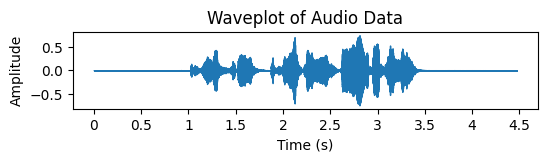

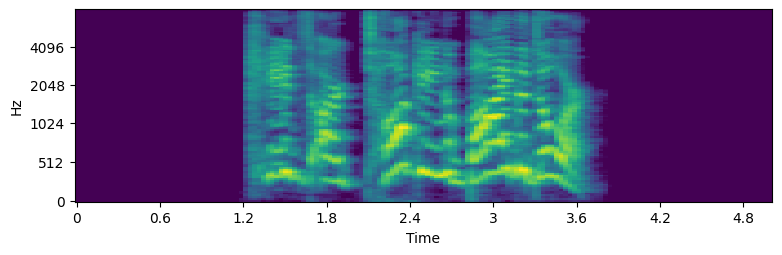

In [43]:
# load audio and downsample to 16000
y, sr = librosa.load(audio_sample['path'].values[0], sr=16000)

# Create wave plot
plt.figure(figsize=(6, 1))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(9,2.5))
librosa.display.specshow(audio_sample['spectro'].values[0],
                         sr=sr, hop_length=512, n_fft=2048,
                         x_axis='time', y_axis='mel',
                         cmap = 'viridis'
                         )
plt.show()

## Split Data

In [13]:
# # split dataset by actors
# all_actors = df_rav['actor'].unique()
# actors_gender = df_rav.groupby('actor')['gender'].unique().reset_index()

# train_actors, tmp = train_test_split(actors_gender, train_size=10, stratify=actors_gender['gender'], random_state=36851234)
# val_actors, test_actors = train_test_split(tmp, train_size=8, stratify=tmp['gender'], random_state=36851234)

# train_actors = train_actors['actor'].tolist()
# val_actors = val_actors['actor'].tolist()
# test_actors = test_actors['actor'].tolist()

# df_train = df_rav[df_rav['actor'].isin(train_actors)]
# df_val = df_rav[df_rav['actor'].isin(val_actors)]
# df_test = df_rav[df_rav['actor'].isin(test_actors)]

In [14]:
# Random data set split
df_train = df_rav.sample(frac=.8, random_state=0)
df_val = df_rav.drop(df_train.index).sample(frac=.5, random_state=0)
df_test = df_rav.drop(df_train.index).drop(df_val.index)

## Setup Pytorch Data Loaders

In [15]:
def get_dataset(df, feats_col, labels_col):
  labels = df[labels_col].values

  # convert from object array in dataframe to floats
  # and convert to numpy array
  feats = df[feats_col]
  feats = [f.astype(float) for f in feats]
  feats = np.array(feats)
  feats = feats[:, None, :, :]

  idxs = df.index.values

  # Setup features and labels as tensors
  X = torch.tensor(feats, dtype=torch.float32)
  y = torch.tensor(labels, dtype=torch.long)
  idxs = torch.tensor(idxs, dtype=torch.long)

  # Create TensorDataset
  dataset = TensorDataset(X, y, idxs)

  return dataset

In [16]:
# setup dataloaders based on previous dataset split
ds_train = get_dataset(df_train, 'spectro', 'emotion')
ds_val = get_dataset(df_val, 'spectro', 'emotion')
ds_test = get_dataset(df_test, 'spectro', 'emotion')

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=1, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False)

# Load and Evaluate Pretrained Model

In [17]:
# get checkpoint
ckpt_link = 'https://uni-bielefeld.sciebo.de/s/eiOiBrhuOENmo0p/download'
ckpt_path = utils.download_file(ckpt_link,
                                'ravdess_model.pth',
                                cache_dir='./data/ravdess/model',
                                extract=False,
                                force_download=False
                                )
ckpt_path

File downloaded to: data/ravdess/model/ravdess_model.pth


PosixPath('data/ravdess/model/ravdess_model.pth')

In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load and Evaluate Trained Model

In [19]:
# To load the best model:
model = models.ResNet(len(LABELS))
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(device);

<ipython-input-19-e100899499d6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))


In [20]:
evaluate.evaluate_model(model, dl_train, criterion, device)
evaluate.evaluate_model(model, dl_val, criterion, device)
_, _, test_preds, test_probs = evaluate.evaluate_model(model, dl_test, criterion, device)

Evaluation Loss: 0.2150, Evaluation Accuracy: 0.9401
Evaluation Loss: 0.1781, Evaluation Accuracy: 0.9375
Evaluation Loss: 0.2852, Evaluation Accuracy: 0.9236


In [21]:
# load probabilities and predictions into dataframe for test dataset
df_test['pred'] = test_preds
df_test['prob'] = test_probs
test_corr = df_test['emotion'] == df_test['pred']
test_corr.astype(int).mean()

0.9236111111111112